In [1]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import numpy as np


In [2]:
KERNELS = (
    "gaussian", "tophat", "cosine"
)

BAND_WIDTHS = (
    0.1, 0.5, 1.0, 1.5, 2
)


In [3]:
def get_data(n: int = 200) -> np.array:
    data = []

    for _ in range(n):
        choice = np.random.randint(0, 11)
        if choice < 9:
            data.append(np.random.normal(5, 1))
        else:
            data.append(np.random.normal(10, 1))

    return np.array(data).reshape(-1, 1)


def mse(data: np.array, density_func, estimate_density_func) -> float:
    return np.mean(
        [(density_func(x) - estimate_density_func(x))**2 for x in data]
        )


def f(x: float) -> float:
    return 0.9*norm.pdf(x, 5, 1) + 0.1*norm.pdf(x, 10, 1)


### 1. a) Draw density function corresponding to theoretical distribution and estimated function

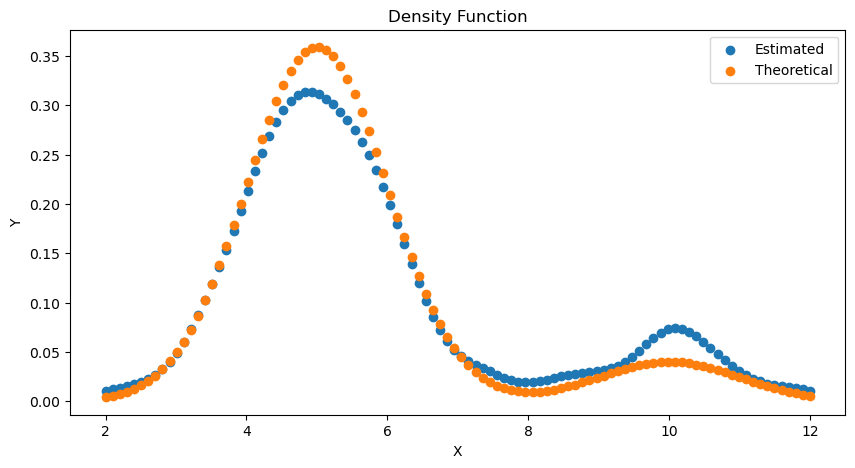

In [25]:
train_data = get_data(n=200)

test_data = np.linspace(2, 12, 100).reshape(-1, 1)

kde = KernelDensity(kernel="gaussian", bandwidth="silverman").fit(train_data)
preds = np.exp(kde.score_samples(test_data))

plt.figure(figsize=(10, 5))
plt.scatter(test_data, preds, label="Estimated")
plt.scatter(test_data, [f(x) for x in test_data], label="Theoretical")
plt.title("Density Function")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


The estimated density closely follows the theoretical density near the central peak, highlighting the KDE's effectiveness in capturing the primary mode of the distribution. However, discrepancies appear in the tail regions and around the secondary peak near x=10, suggesting areas where the estimation may not perfectly capture less dominant features of the distribution.

### 1. b) Analyse how the error depends on sample size n

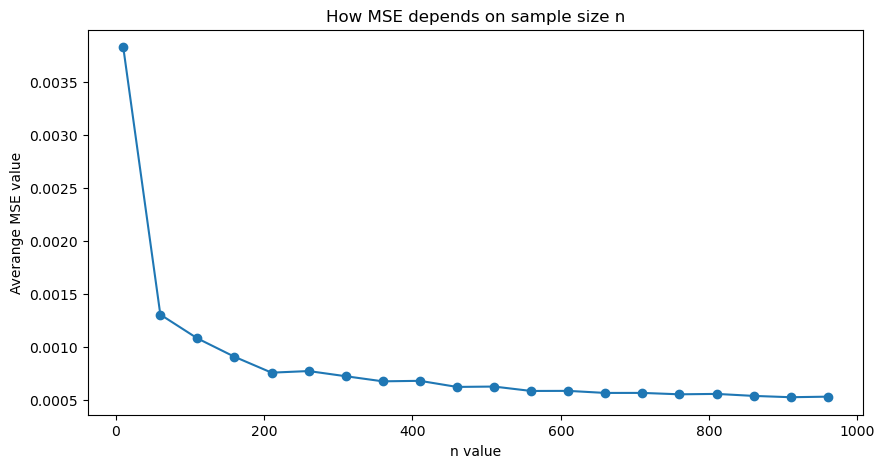

In [5]:
test_data = np.linspace(2, 12, 100).reshape(-1, 1)
real_values = np.array([f(x) for x in test_data]).reshape(1, -1)[0]

n_values = []
mse_values = []

HOW_MANY = 100
for n in range(10, 1000, 50):
    mse_tmp = 0
    for i in range(HOW_MANY):
        train_data = get_data(n=n)

        kde = KernelDensity(kernel="gaussian", bandwidth="silverman").fit(train_data)
        preds = np.exp(kde.score_samples(test_data))

        mse_value = mean_squared_error(preds, real_values)

        mse_tmp += mse_value

    n_values.append(n)
    mse_values.append(mse_tmp/HOW_MANY)


plt.figure(figsize=(10, 5))
plt.plot(n_values, mse_values, "-o")
plt.title("How MSE depends on sample size n")
plt.xlabel("n value")
plt.ylabel("Averange MSE value")
plt.show()


As we can see, a larger training dataset results in a lower MSE - which is a desirable and logical result.

### 1. c) Analyse the influence of different kernel functions as well as smoothing parameters

As we came to the conclusion in the laboratories, there is no point in checking kernels other than "silverman" because they do not work.

In [6]:
pass


### 2. Generate sample X1, . . . , Xn of size n = 200 from Gauusian mixture model described above. Compare two methods (compute MSE for both of them)

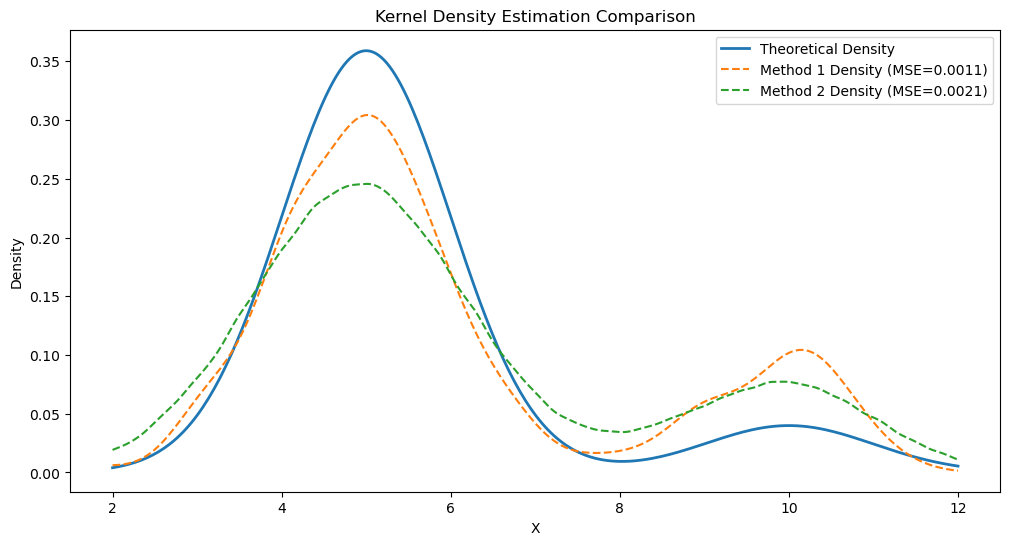

In [7]:
X = get_data(n=200)


# Method 1: Direct KDE
kde1 = KernelDensity(kernel="gaussian", bandwidth="silverman")
kde1.fit(X.reshape(-1, 1))


# Method 2: Generate artificial sample and then KDE
k = 1000  # larger than n
h = 1.06 * X.std() * n**(-1/5)  # Silverman"s rule of thumb for bandwidth
X_prime = X + np.random.normal(0, h, k)
kde2 = KernelDensity(kernel="gaussian", bandwidth="silverman")
kde2.fit(X_prime.reshape(-1, 1))


# Evaluate MSE on a grid of points
grid = np.linspace(2, 12, 300).reshape(-1, 1)
true_density = f(grid.ravel())

density1 = np.exp(kde1.score_samples(grid))
density2 = np.exp(kde2.score_samples(grid))

mse1 = np.mean((true_density - density1)**2)
mse2 = np.mean((true_density - density2)**2)

plt.figure(figsize=(12, 6))
plt.plot(grid, true_density, label="Theoretical Density", linewidth=2)
plt.plot(grid, density1, "--", label=f"Method 1 Density (MSE={mse1:.4f})")
plt.plot(grid, density2, "--", label=f"Method 2 Density (MSE={mse2:.4f})")
plt.title("Kernel Density Estimation Comparison")
plt.xlabel("X")
plt.ylabel("Density")
plt.legend()
plt.show()


The plot compares the kernel density estimates from two methods against a theoretical Gaussian mixture density. Method 1, using direct kernel density estimation, more closely approximates the theoretical density (MSE=0.0011) than Method 2, which generates an artificial sample with added noise (MSE=0.0021). Overall, Method 1 provides a more accurate and tighter fit to the theoretical distribution, especially at the main peak around x=5.

### 3. Select any dataset corresponding to binary classification problem wih quantitative variables.

In [17]:
df = pd.read_csv("heart_statlog_cleveland_hungary_final.csv")

df


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,45,1,1,110,264,0,0,132,0,1.2,2,1
1186,68,1,4,144,193,1,0,141,0,3.4,2,1
1187,57,1,4,130,131,0,0,115,1,1.2,2,1
1188,57,0,2,130,236,0,2,174,0,0.0,2,1


In [8]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
    )

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

kde = KernelDensity(kernel="gaussian", bandwidth="silverman").fit(train_data)


In [10]:
class KDEBayes:
    def __init__(self, bandwidth: float) -> None:
        self.bandwidth = bandwidth
    
    def fit(self, X: pd.DataFrame, y: pd.DataFrame) -> None:
        self.classes_ = np.unique(y)

        self.models_ = {
            cls: KernelDensity(bandwidth=self.bandwidth)
            for cls in self.classes_
            }

        for cls in self.classes_:
            self.models_[cls].fit(X[y == cls])
    
    def predict(self, X: pd.DataFrame) -> float:
        scores = np.array(
            [self.models_[cls].score_samples(X) for cls in self.classes_]
            ).T

        return self.classes_[np.argmax(scores, axis=1)]


In [11]:
# Naive Bayes method (with kernel density estimator)
kde_bayes = KDEBayes(bandwidth="silverman")
kde_bayes.fit(X_train_scaled, y_train)

# Naive Bayes method (with Gaussian approximation of the density)
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)

# Naive Bayes method (with discretization of quantitative features)
est = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="uniform")
X_binned = est.fit_transform(X_train)
nb_disc = CategoricalNB()
nb_disc.fit(X_binned, y_train)

# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)


c:\Users\Studia\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


LinearDiscriminantAnalysis()

In [12]:
models = {
    "KDEBayes": kde_bayes,
    "GaussianNB": gnb, 
    "CategoricalNB with discretization": nb_disc,
    "LDA": lda,
    }

accuracy_scores = {}

for name, model in models.items():
    if name == "KDEBayes":
        y_pred = model.predict(X_test_scaled)
    else:
        if name == "CategoricalNB with discretization":
            X_test_transformed = est.transform(X_test)
        else:
            X_test_transformed = X_test_scaled
        y_pred = model.predict(X_test_transformed)

    y_pred = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = y_pred
    print(f"Accuracy of {name}: {y_pred:.4f}")


Accuracy of KDEBayes: 0.9118
Accuracy of GaussianNB: 0.8571
Accuracy of CategoricalNB with discretization: 0.8487
Accuracy of LDA: 0.8529


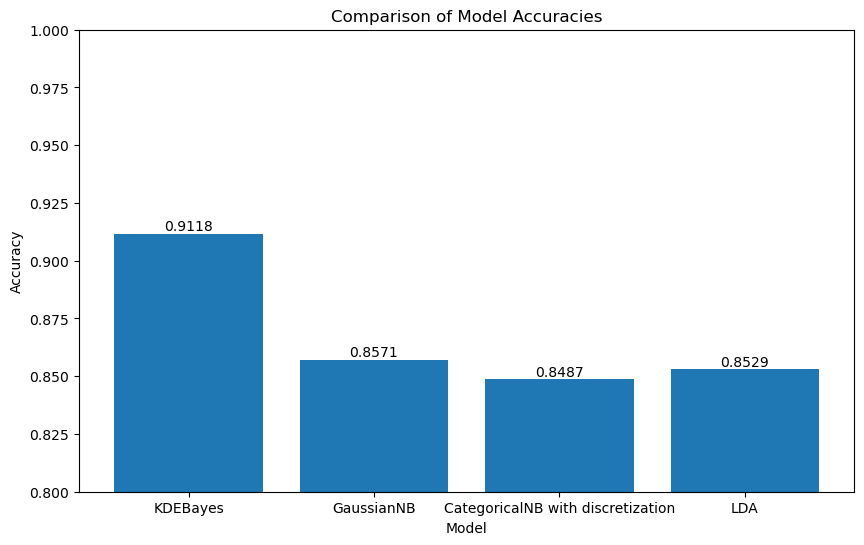

In [18]:
names = list(accuracy_scores.keys())
values = list(accuracy_scores.values())

plt.figure(figsize=(10, 6))
plt.bar(names, values)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.ylim(0.8, 1.0)

for i, v in enumerate(values):
    plt.text(i, v, f"{v:.4f}", ha="center", va="bottom")

plt.show()


KDEBayes performs best with an accuracy of 0.9118, while GaussianNB, CategoricalNB with discretization, and LDA follow with accuracies of 0.8571, 0.8487, and 0.8529, respectively. This suggests that KDEBayes, which incorporates kernel density estimation, might be more effective in capturing the nuances in data distribution compared to the other methods.